# hdf5plugin benchmark

This notebook displays benchmark of the HDF5 compression filters provided by [hdf5plugin](https://github.com/silx-kit/hdf5plugin) as well as "gzip" and "lzf".
Benchmarks can be run with the [benchmark.py](benchmark.py) companion script and saved as json files that this notebooks can load and display.

## Preparation

Dependencies: h5py ipympl matplotlib numpy

### Install `hdf5plugin`

- Pre-compiled package:
  - Only SSE2 SIMD instructions enabled
  - OpenMP disabled
  - `pip install hdf5plugin` or `conda install -c conda-forge hdf5plugin`
- From source:
  - SIMD instructions available on host enabled
  - OpenMP enabled
  - `pip install hdf5plugin --no-binary hdf5plugin`

### Get dataset

Download benchmark dataset: http://www.silx.org/pub/pyFAI/pyFAI_UM_2020/data_ID13/kevlar.h5

In [ ]:
!wget -O /dev/shm/kevlar.h5 http://www.silx.org/pub/pyFAI/pyFAI_UM_2020/data_ID13/kevlar.h5

### What hardware is available

The CPU layout can have a significative impact on performance for multi-threaded execution

In [1]:
!numactl --hardware

available: 2 nodes (0-1)
node 0 cpus: 0 2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38
node 0 size: 192072 MB
node 0 free: 170763 MB
node 1 cpus: 1 3 5 7 9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39
node 1 size: 193489 MB
node 1 free: 164284 MB
node distances:
node   0   1 
  0:  10  21 
  1:  21  10 


In [2]:
!pip install h5glance


   ---------------------------------------- 2/2 [h5glance]



### Load plotting function

In [1]:
# Initialization
#%matplotlib inline
%matplotlib widget

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

import numpy
import h5py
import hdf5plugin
from h5glance import H5Glance

In [6]:
# Plot helper

from typing import NamedTuple

class Result(NamedTuple):
    """Store benchmark result"""

    raw_nbytes: int
    compressed_nbytes: int
    write_duration: float
    read_duration: float

    compression_rate = property(
        lambda self: self.raw_nbytes / self.compressed_nbytes)
    write_speed = property(
        lambda self: (self.raw_nbytes / 1024**2) / self.write_duration,
        doc="Unit: MB/sec")
    read_speed = property(
        lambda self: (self.raw_nbytes / 1024**2) / self.read_duration,
        doc="Unit: MB/sec")

    
def display_results(title: str='', key=None, **results):
    """Plot comparison of compression results.
    
    :param title: Additional dataset name
    :param key: Key function to customize the sort
    :param **results: {compression-name: Result} mapping 
    """
    # Sort results by compression rate
    results = dict(sorted(
        results.items(),
        key=(lambda item: item[1].compression_rate) if key is None else key,
    ))
    
    names = list(results.keys())
    write_speed = numpy.array([r.write_speed for r in results.values()])
    read_speed = numpy.array([r.read_speed for r in results.values()])
    c_rate = numpy.array([r.compression_rate for r in results.values()])
    
    #print(f"hdf5plugin_config: {results[names[0]].config}")

    fig, axes = plt.subplots(1, 2)
    speed_plt, c_rate_plt = axes

    fig.suptitle(title)

    ticks = numpy.arange(len(names))

    # Speed
    speed_plt.barh(y=ticks, width=write_speed, height=0.4, align='edge', label="Write")
    speed_plt.barh(y=ticks-.4, width=read_speed, height=0.4, align='edge', label="Read")
    speed_plt.set_xlabel("Speed [MB/s]")
    speed_plt.autoscale(axis='y')
    speed_plt.yaxis.set_ticks(ticks)
    speed_plt.yaxis.set_ticklabels(names, fontsize=8)
    speed_plt.set_ylim(-0.5, len(ticks)-0.5)
    speed_plt.grid(axis="x")
    speed_plt.legend()
    
    # Compression ratio
    c_rate_plt.barh(y=ticks, width=c_rate)
    c_rate_plt.set_xlabel("Compression rate")
    c_rate_plt.autoscale(axis='y')
    c_rate_plt.yaxis.set_ticks(ticks)
    c_rate_plt.yaxis.set_ticklabels([''] * len(ticks))
    c_rate_plt.set_ylim(-0.5,len(ticks)-0.5)
    c_rate_plt.axvline(1, color="red")
    c_rate_plt.grid(axis="x")

    fig.tight_layout()

    # Tooltip
    tooltip = c_rate_plt.annotate(
        "", (0, 0), backgroundcolor="lightyellow",
        verticalalignment="top", xycoords='figure pixels')
    tooltip.set_visible(False)

    def hover(event):
        if event.inaxes in (speed_plt, c_rate_plt):
            index = numpy.clip(round(event.ydata), 0, len(names)-1)
            tooltip.set_text(
                f"{names[index]}\n"
                f"Comp. Rate: {c_rate[index]:.2f}x\n"
                f"Write: {write_speed[index]:.1f}MB/s\n"
                f"Read: {read_speed[index]:.1f}MB/s")
            tooltip.set_x(event.x + 15)
            tooltip.set_y(event.y)
            tooltip.set_visible(True)
        else:
            tooltip.set_visible(False)
        fig.canvas.draw_idle()
    
    def resize(event):
        fig.tight_layout()

    fig.canvas.mpl_connect("motion_notify_event", hover)
    fig.canvas.mpl_connect("resize_event", resize)

### Display information

In [7]:
import os
import sys

print('Python:', sys.version)

config = hdf5plugin.get_config()
print(f"""hdf5plugin:
* Version: {hdf5plugin.version}
* Build config:
{'''
'''.join(f'  - {k}: {v}' for k, v in config.build_config._asdict().items())}
""")

Python: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]
hdf5plugin:
* Version: 5.1.0
* Build config:
  - openmp: False
  - native: False
  - bmi2: False
  - sse2: True
  - ssse3: False
  - avx2: False
  - avx512: False
  - cpp11: True
  - cpp14: True
  - cpp20: True
  - ipp: False
  - filter_file_extension: .dll
  - embedded_filters: ('blosc', 'blosc2', 'bshuf', 'bzip2', 'fcidecomp', 'lz4', 'sperr', 'sz', 'sz3', 'zfp', 'zstd')



## Benchmark results

In [8]:
import json

benchmarks = json.load(open("benchmark.json"))
config = benchmarks["config"]
results = {k: Result(**v) for k, v in benchmarks["results"].items()}

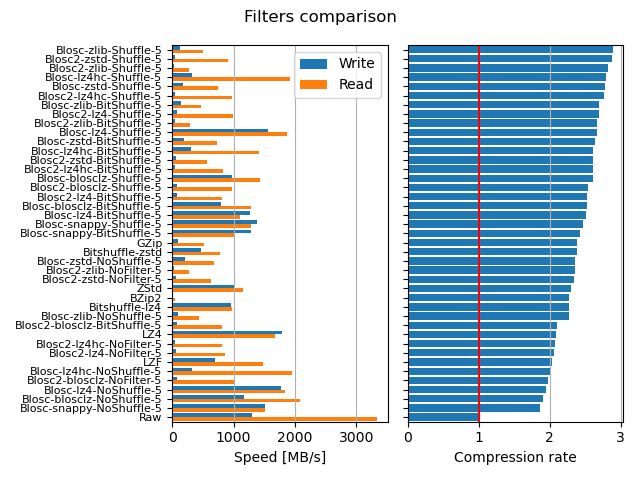

In [9]:
display_results(
    title="Filters comparison",
    **results
)

In [10]:

DEFAULT_FILTERS = {  # Filters available with h5py/libhdf5
    "Raw": None,
    "GZip": "gzip",
    "LZF": "lzf",
}

FILTERS = {
    **DEFAULT_FILTERS
}

try:
    import hdf5plugin

    LOSSLESS_FILTERS = {
        "BZip2": hdf5plugin.BZip2(),
        "LZ4": hdf5plugin.LZ4(),
        "ZStd": hdf5plugin.Zstd(),
    }
    FILTERS.update(**LOSSLESS_FILTERS)

    BITSHUFFLE_FILTERS = {
        "Bitshuffle-lz4": hdf5plugin.Bitshuffle(cname='lz4'),
        "Bitshuffle-zstd": hdf5plugin.Bitshuffle(cname='zstd'),
    }
    FILTERS.update(**BITSHUFFLE_FILTERS)
        
    BLOSC_FILTERS = {}
    for cname in ('lz4', 'blosclz', 'lz4', 'lz4hc', 'snappy', 'zlib', 'zstd'):
        for shuffle_name, shuffle in [('NoShuffle', hdf5plugin.Blosc.NOSHUFFLE),
                                      ('Shuffle', hdf5plugin.Blosc.SHUFFLE),
                                      ('BitShuffle', hdf5plugin.Blosc.BITSHUFFLE)]:
            for clevel in [5]: #(1, 3, 5, 9):
                BLOSC_FILTERS[f"Blosc-{cname}-{shuffle_name}-{clevel}"] = hdf5plugin.Blosc(
                    cname=cname, clevel=clevel, shuffle=shuffle)
    FILTERS.update(**BLOSC_FILTERS)

    BLOSC2_FILTERS = {}
    for cname in ('lz4', 'blosclz', 'lz4', 'lz4hc', 'zlib', 'zstd'):
        for filters_name, filters in [('NoFilter', hdf5plugin.Blosc2.NOFILTER),
                                    ('Shuffle', hdf5plugin.Blosc2.SHUFFLE),
                                    ('BitShuffle', hdf5plugin.Blosc2.BITSHUFFLE)]:
            for clevel in [5]: # (1, 3, 5, 9):
                BLOSC2_FILTERS[f"Blosc2-{cname}-{filters_name}-{clevel}"] = hdf5plugin.Blosc2(
                    cname=cname, clevel=clevel, filters=filters)
    FILTERS.update(**BLOSC2_FILTERS)

except Exception as e:
    print("Unable to load hdf5plugin compression filters:")
    traceback.print_exc()

In [13]:
list(FILTERS.keys())

['Raw',
 'GZip',
 'LZF',
 'BZip2',
 'LZ4',
 'ZStd',
 'Bitshuffle-lz4',
 'Bitshuffle-zstd',
 'Blosc-lz4-NoShuffle-5',
 'Blosc-lz4-Shuffle-5',
 'Blosc-lz4-BitShuffle-5',
 'Blosc-blosclz-NoShuffle-5',
 'Blosc-blosclz-Shuffle-5',
 'Blosc-blosclz-BitShuffle-5',
 'Blosc-lz4hc-NoShuffle-5',
 'Blosc-lz4hc-Shuffle-5',
 'Blosc-lz4hc-BitShuffle-5',
 'Blosc-snappy-NoShuffle-5',
 'Blosc-snappy-Shuffle-5',
 'Blosc-snappy-BitShuffle-5',
 'Blosc-zlib-NoShuffle-5',
 'Blosc-zlib-Shuffle-5',
 'Blosc-zlib-BitShuffle-5',
 'Blosc-zstd-NoShuffle-5',
 'Blosc-zstd-Shuffle-5',
 'Blosc-zstd-BitShuffle-5',
 'Blosc2-lz4-NoFilter-5',
 'Blosc2-lz4-Shuffle-5',
 'Blosc2-lz4-BitShuffle-5',
 'Blosc2-blosclz-NoFilter-5',
 'Blosc2-blosclz-Shuffle-5',
 'Blosc2-blosclz-BitShuffle-5',
 'Blosc2-lz4hc-NoFilter-5',
 'Blosc2-lz4hc-Shuffle-5',
 'Blosc2-lz4hc-BitShuffle-5',
 'Blosc2-zlib-NoFilter-5',
 'Blosc2-zlib-Shuffle-5',
 'Blosc2-zlib-BitShuffle-5',
 'Blosc2-zstd-NoFilter-5',
 'Blosc2-zstd-Shuffle-5',
 'Blosc2-zstd-BitShuffle

In [18]:
FILTERS['Blosc2-zstd-BitShuffle-5'] == FILTERS['Blosc2-zstd-BitShuffle-5']

True